In [1]:
import xarray as xr
import numpy as np
import os
import xesmf as xe
from compute_ETo import *
from py_ecosystem import *

#### Surface resistance by inversion of Penman Monteith

#### $r_{s} = \frac{r_{a}}{\gamma}[\frac{0.408\Delta R_{n} + \gamma \frac{900}{T+273} u_{2}(e_{s} - e_{a})}{\lambda ET} -\Delta - \gamma] $

By substituting $r_{a}$ with $\frac{208}{u_{2}}$, $r_{s}$ can be expressed as:  


#### $r_{s} = \frac{208}{u_{2} \gamma}[\frac{\Delta R_{n} + \gamma \frac{900}{T+273} u_{2}(e_{s} - e_{a})}{\lambda ET} -\Delta - \gamma] $


${\lambda ET}$ (mm) represent the latent heat flux and $R_{n}$ is in units of $MJ/m^{2}/day$.

The inputs have also been preprocessed from the gridded_ETo notebook

### Read inputs

In [2]:
Rn = xr.open_dataset(r"D:\VUB\_data\mswx_ETo_inputs\Rn_ROI_10km.nc")
vpd = xr.open_dataset(r"D:\VUB\_data\mswx_ETo_inputs\vpd_10km.nc") 
mswx_tmean = xr.open_dataset(r"D:\VUB\_data\mswx_ETo_inputs\Tmean_KE_data.nc")
mswx_wind  = xr.open_dataset(r"D:\VUB\_data\mswx_ETo_inputs\wind_KE_data.nc")
delta = xr.open_dataset(r"D:\VUB\_data\mswx_ETo_inputs\delta_10km.nc")
gamma = xr.open_dataset(r"D:\VUB\_data\mswx_ETo_inputs\psychrometric_constant_500m.nc")
modis_LE = xr.open_dataset(r"D:\VUB\_data\nc_files\modis_LE_2000_2023.nc")
modis_lai = xr.open_dataset(r"D:\VUB\_data\nc_files\modis_terra_LAI_2000_2024.nc")

In [3]:
#convert wind speed to 2m
wind_2m = compute_2m_wind_speed(mswx_wind,10)

#select time period
mswx_wind = mswx_wind.sel(time=slice("2000-01-01",'2023-10-26'))
mswx_tmean = mswx_tmean.sel(time=slice("2000-01-01",'2023-10-26'))
modis_LE = modis_LE.sel(time=slice("2000-01-01",'2023-10-26'))

### Interpolate datasets to uniform grid

In [4]:
# Define the desired resolution
resolution = 0.027  # Degrees

# Create the target grid with the new resolution
lat_start = modis_LE.lat.min()
lat_end = modis_LE.lat.max()
lon_start = modis_LE.lon.min()
lon_end = modis_LE.lon.max()

ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(lat_start, lat_end + 0.5*resolution, resolution), {"units": "degrees_north"}),
        "lon": (["lon"], np.arange(lon_start, lon_end + 0.5*resolution, resolution), {"units": "degrees_east"}),
    }
)

datasets = [Rn, vpd, mswx_tmean, wind_2m, delta, gamma,modis_LE]
dataset_names = ["Rn", "vpd", "mswx_tmean", "mswx_wind", "delta", "gamma","modis_LE"]

# Regrid all datasets to the new resolution
common_grid = {}
for ds, name in zip(datasets, dataset_names):
    regridder = xe.Regridder(ds, ds_out, "bilinear")
    ds_out = regridder(ds)
    common_grid[name] = ds_out

In [5]:
regridder = xe.Regridder(modis_lai, ds_out, "bilinear")

In [6]:
modis_lai_grid = regridder(modis_lai)

In [7]:

# Broadcast gamma to have the same dimensions as modis_LE. xr.broadcast returns a tuple with the broadcasted variables
gamma_broadcasted, _ = xr.broadcast(common_grid['gamma'], common_grid['modis_LE'])

In [8]:

# Reorder the dimensions of gamma_broadcasted
gamma_broadcasted = gamma_broadcasted.transpose("time", "lat", "lon")

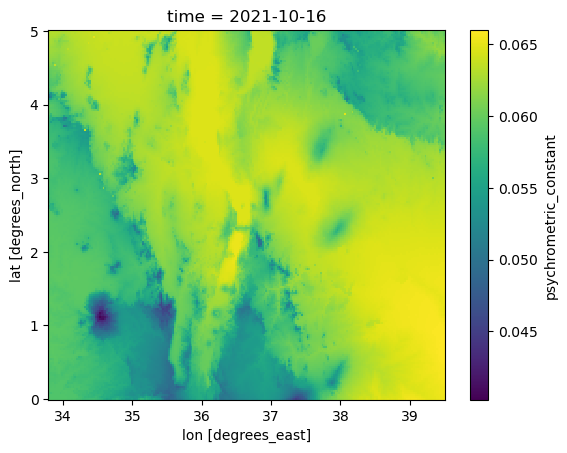

In [9]:
gamma_broadcasted['psychrometric_constant'][1000].plot()

#### Compute surface conductance

In [10]:
#Group the variables to match MODIS LE frequency
#Rn, Tmean, wind, delta, gamma, LE

grouped_data = {}
keys_list = list(common_grid.keys())[:-2]  # Get all keys except the last two
for key in keys_list:
        grouped_data[key] = extract_grouped_data(common_grid["modis_LE"], common_grid[key], agg_func="mean")

In [11]:
gamma = common_grid['gamma']['psychrometric_constant']
delta = grouped_data['delta']['air_temperature']

ra_term = 208 / (grouped_data["mswx_wind"]['wind_speed'] * gamma_broadcasted['psychrometric_constant'])  #aerodynamic resistance term
rad_term = 0.408 * grouped_data["delta"]['air_temperature'] * grouped_data["Rn"]['Rn']  #radiation term in mm/day
water_demand_part= gamma_broadcasted['psychrometric_constant'] * grouped_data['mswx_wind']['wind_speed']  * grouped_data["vpd"]['VPD'] * 900 / (grouped_data["mswx_tmean"]['air_temperature'] + 273)  #water demand term (mm/day)

In [12]:
#Convert LE to from J/2/day to MJ/m2/day to mm/day
LE= (common_grid['modis_LE'].where(common_grid['modis_LE']<5000)) * 10000 * 1e-6 * 0.408 #10000 is scaling factor, 1e-6 is conversion factor from J to MJ
LE_modified = LE.where(LE>0) #mm/day

In [13]:
rs = ra_term *((rad_term + water_demand_part)/LE_modified['LE'] - gamma - delta)
rs = rs.where(rs>0)

surface_conductance = 1/rs

In [20]:
LAI = 0.1 * modis_lai_grid['LAI']  #0.1 is the scale factor
rc_LAI =LAI/200

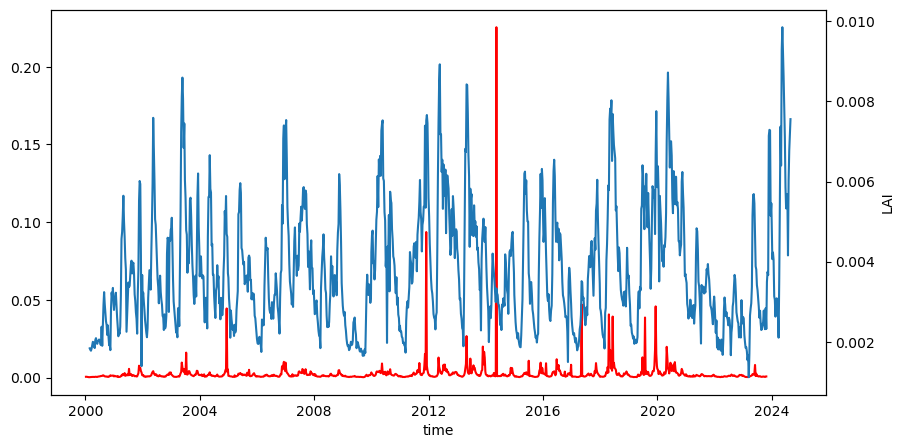

In [27]:
fig,ax = plt.subplots(figsize=(10,5))
ax2 = ax.twinx()
surface_conductance = 1/rs
surface_conductance.sel(lat = slice(0,1),lon = slice(36.5,37.1)).mean(dim = ['lat','lon']).plot(ax=ax,label = 'Surface conductance', c = 'r')
rc_LAI.sel(lat = slice(0,1),lon = slice(36.5,37.1)).mean(dim = ['lat','lon']).plot(ax=ax2,label = 'LAI')
#plt.legend()

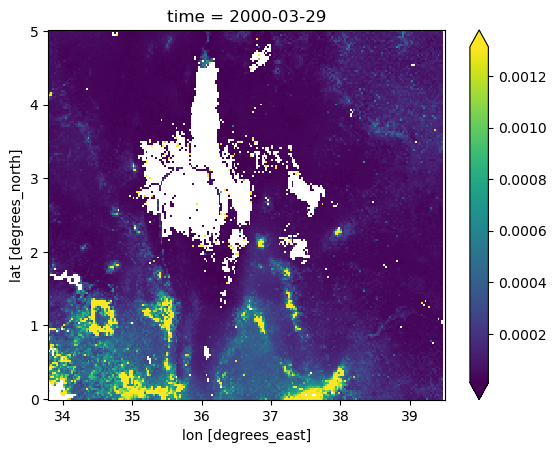

In [25]:
surface_conductance[10].plot(robust = True)